# Titanic Dataset

**Team Members:**
* Peter Felt
* Kuheli Sen
* Sophia Arackal
* Shahid Abulaziz
* Chris Pellerito
* Dustin Berry

# My submission Public Score for Team's submission: 0.78229

In [1]:
# Import Basic Packages for data exploration and wrangling
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats

# Import visualization packages
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import datetime       # Added for version 4 (to post output file with date/time)

# sklearn pre-processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import classification_report,confusion_matrix,make_scorer,f1_score

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# added kfolds 
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Data Load and Exploration

In [2]:
titanic_tr = pd.read_csv('../input/titanic/train.csv')
titanic_tst = pd.read_csv('../input/titanic/test.csv')

In [3]:
titanic_tr.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


**Initial Column Types (prior to deep inspection):**

Categorical Variables:
* Pclass
* Sex (might be binary)
* SibSp
* Parch
* Embarked

Continuous Variables:
* Age
* Fare

Natural Language:
* Name
* Cabin

In [4]:
# Verify column types
titanic_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Verified data ranges for age and fare
# Information shows null values; summarize the number of null values
titanic_tr.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# SHow the divide between those who survived and those who did not
titanic_tr['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
# Show potential values of all categorical variables
cat_vars = ['Pclass','Sex','SibSp','Parch','Embarked']

for var in cat_vars :
    print(var)
    print('==============================')
    print(titanic_tr[var].value_counts())
    print('')
    print('')


Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64


Sex
male      577
female    314
Name: Sex, dtype: int64


SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


Embarked
S    644
C    168
Q     77
Name: Embarked, dtype: int64




In [8]:
# Visualize numeric ranges
cont_var = ['Age','Fare']

fig = make_subplots(rows=1, cols=2)

for idx, var in enumerate(cont_var):
    fig.add_trace(go.Violin(y=titanic_tr[var], box_visible=True, line_color='white', meanline_visible=True, fillcolor='darkturquoise', opacity=0.5, 
                           points='all', x0=var), 1, idx + 1) 

fig.update_layout(height=800, width = 1200, title_text = 'Continuous Variable Distribution', showlegend=False, template='plotly_dark')

In [9]:
# There are clear outliers on the Fare variable, though they are likely valid due to the high cost of first class tickets.

# View split violin plots, showing those that survived and those that did not.
fig = make_subplots(rows = 1, cols = 2)

for idx, var in enumerate(cont_var):
    fig.add_trace(go.Violin(y=titanic_tr[var][ titanic_tr['Survived'] == 1 ],
                            line_color='white', fillcolor='darkturquoise', opacity=0.5, 
                            legendgroup='Yes', name='Yes', side='negative', scalegroup='Yes',
                       x0=var), 1, idx + 1)
    fig.add_trace(go.Violin(y=titanic_tr[var][ titanic_tr['Survived'] == 0 ],
                            line_color='white', fillcolor='darkorange', opacity=0.5, 
                            legendgroup='Yes', name='No', side='positive', scalegroup='No',
                       x0=var), 1, idx + 1)

fig.update_traces(meanline_visible=True)
fig.update_layout(height=800, width=1200, violinmode='overlay',
                  title_text = 'Continuous Variable Distribution - Survived Compared', 
                  template="plotly_dark")
fig.show()

The graph above helps to determine how to manage outliers.  Generally speaking, those above the age of 70 did not survive.  Also, generally speaking, those who paid a far above $100 survived.  

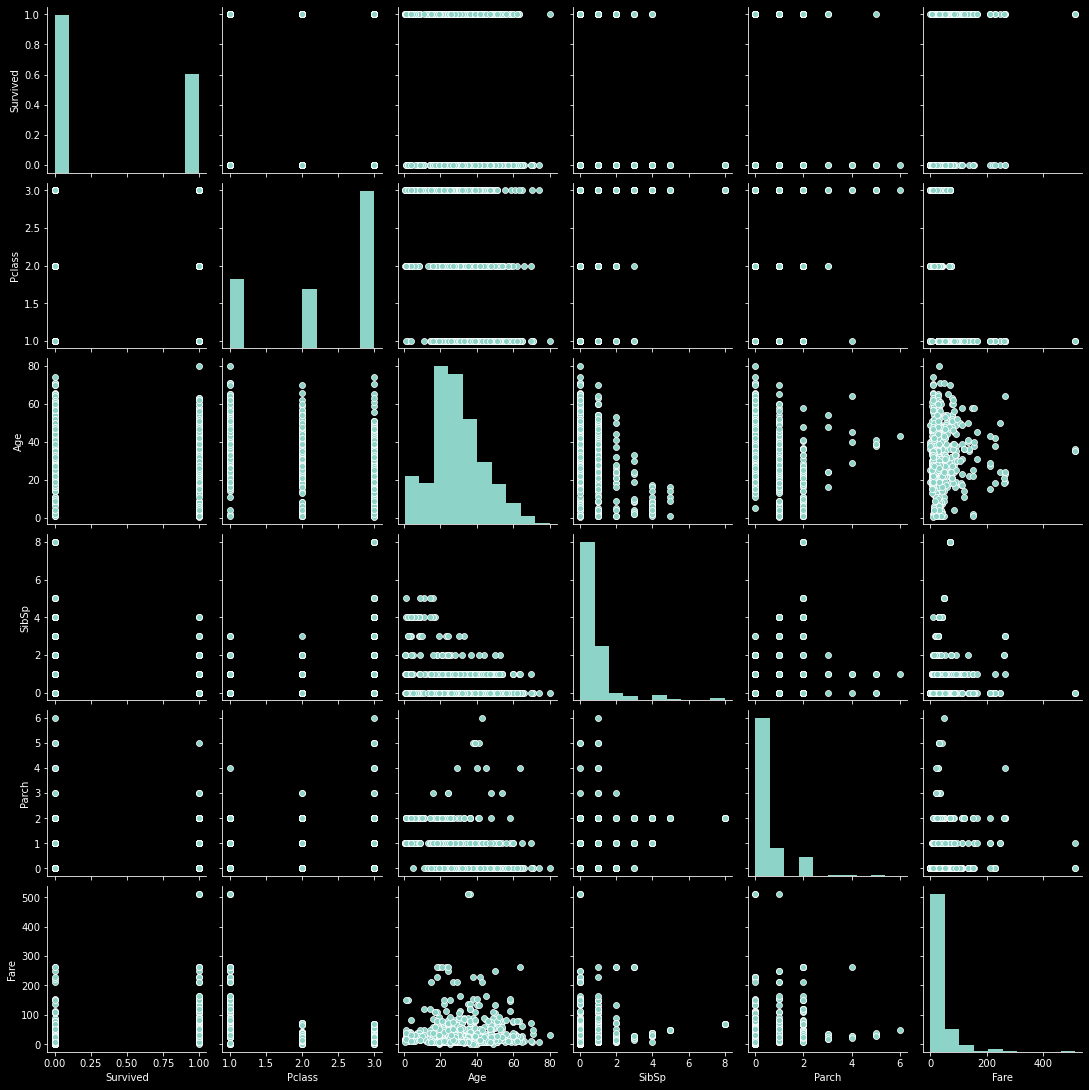

In [10]:
# Display an sns plot for all numeric data types
titanic_num = titanic_tr.select_dtypes('number').drop(columns=['PassengerId'])
plt.style.use('dark_background')
sns.pairplot(titanic_num)

In [11]:
# View using a heatmap
corr = titanic_num.corr()
fig = px.imshow(corr)
fig.update_layout(title_text = 'Correlation Heat Map - Numerical Fields', template="plotly_dark")
fig.show()

# Data Transformation and Pre-Processing

In [12]:
# Combine Train and Test, ensuring that all pre-processing steps are managed simultaneously
train_rows = titanic_tr.shape[0]
test_rows = titanic_tst.shape[0]
print('Rows in the train dataset: ', train_rows)
print('Rows in the test dataset: ', test_rows)
titanic_cmb = pd.concat([titanic_tr.iloc[:, 2:], titanic_tst.iloc[:, 1:]])

Rows in the train dataset:  891
Rows in the test dataset:  418


In [13]:
# =====================================================
# Begin major updates for version 4
# =====================================================

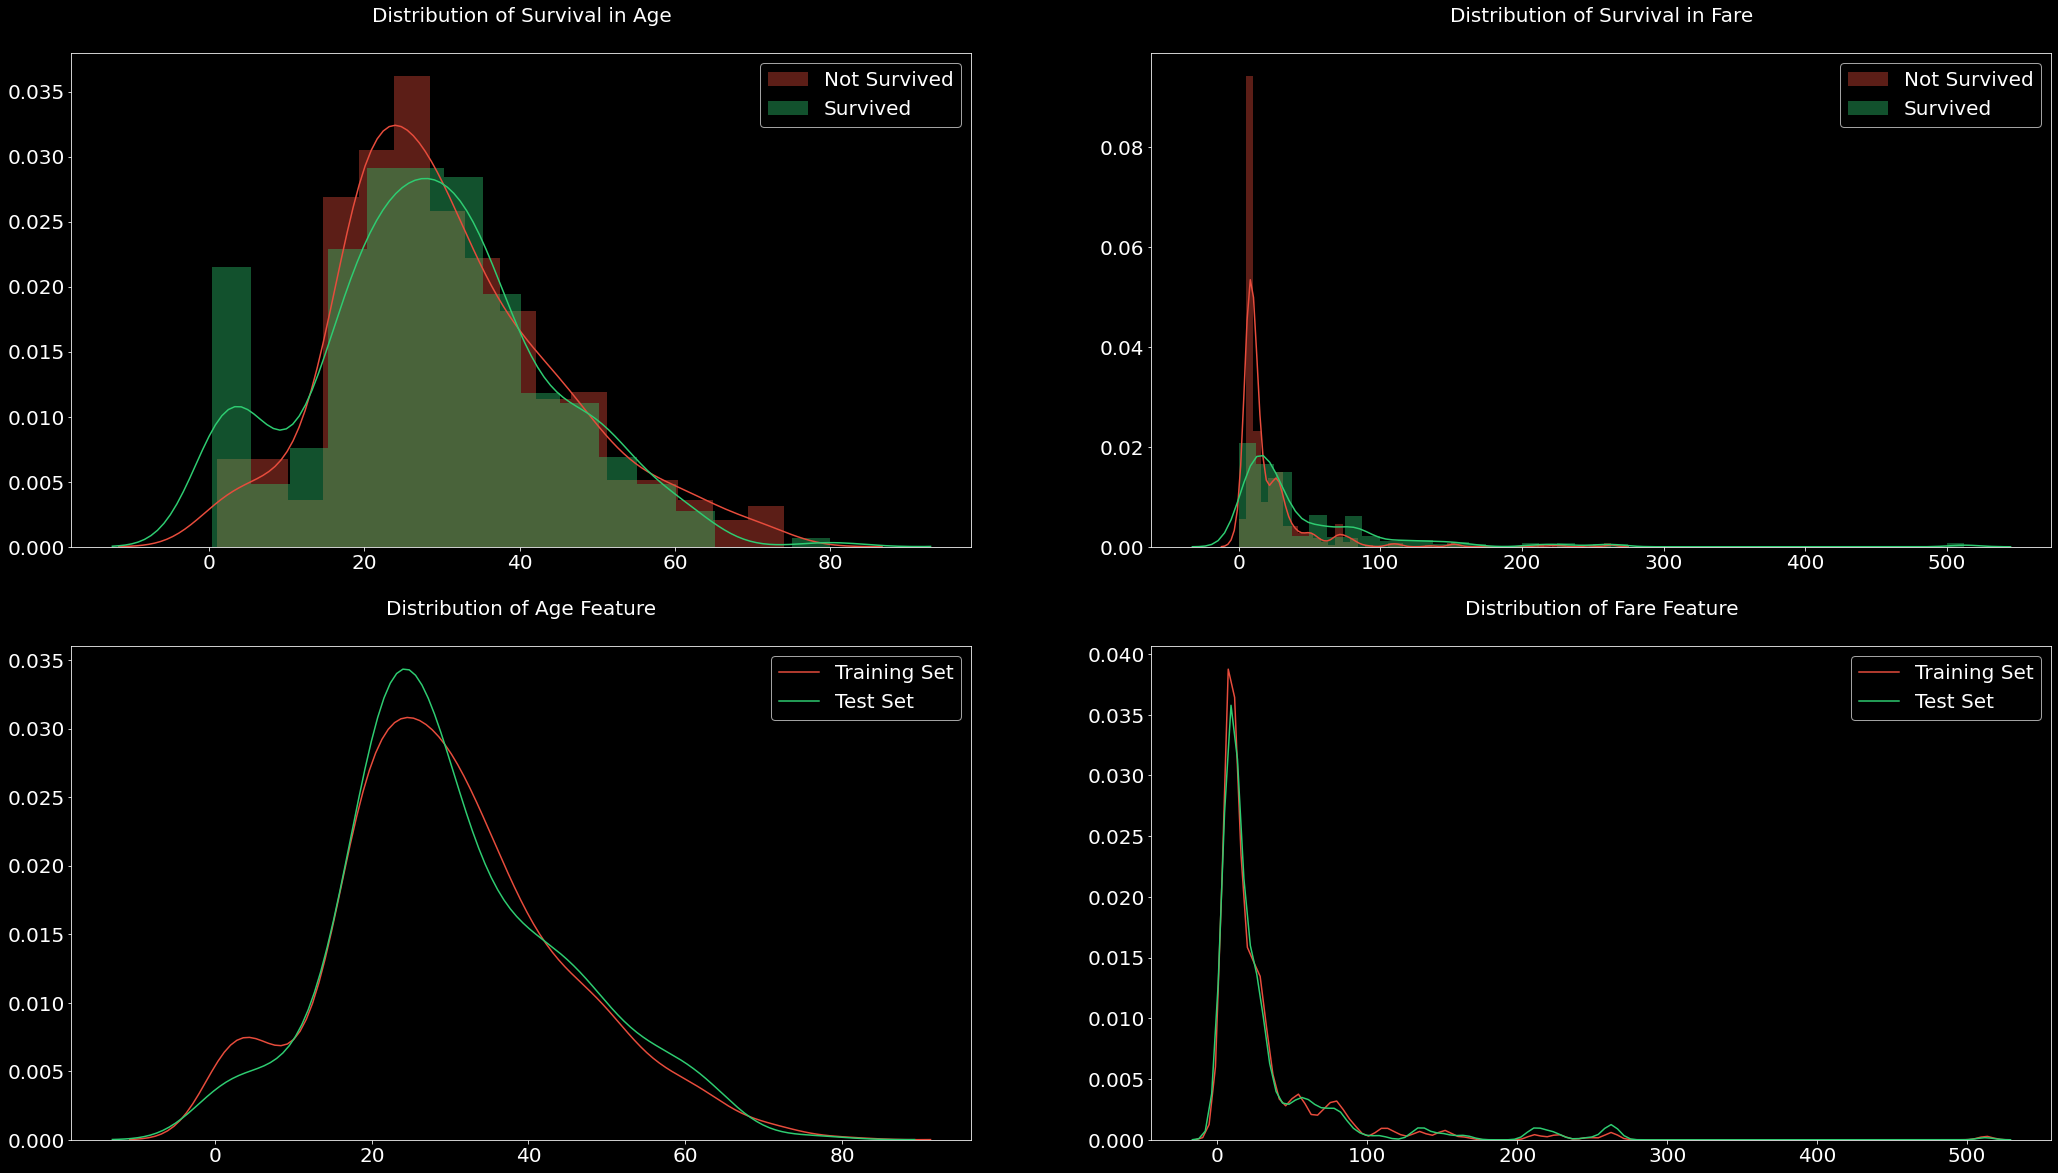

In [14]:
cont_features = ['Age', 'Fare']
surv = titanic_tr['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(titanic_tr[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(titanic_tr[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(titanic_tr[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(titanic_tst[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

In [15]:
# * From the graphs above, the distribution of `Age` feature shows that children younger than 15 has a higher survival rate than any of the other age groups
# * From the graphs above, the distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

In [16]:
pd.options.mode.chained_assignment = None  # default='warn'

# Manage outliers, using the extremes listed above
titanic_cmb.Age[titanic_cmb.Age >= 70] = 70
titanic_cmb.Fare[titanic_cmb.Fare >= 100] = 100

# Add a new column, showing if there was a cabin assigned
titanic_cmb['AssignedCabin'] = titanic_cmb['Cabin'].fillna(0)
titanic_cmb.AssignedCabin = np.where(titanic_cmb.AssignedCabin != 0, 1, 0)

# Convert the Sex column to binary IsMale
titanic_cmb['IsMale'] = np.where(titanic_cmb.Sex == 'male', 1, 0)

# Add a column for family size, which includes Parch (parents and children), SibSp (sibblings and spouses) plus the individual
titanic_cmb['FamCt'] = titanic_cmb['Parch'] + titanic_cmb['SibSp'] + 1

# Arrange into t-shirt type sizing columns
titanic_cmb['FamilySize'] = np.select([
    titanic_cmb['FamCt'] == 1,
    titanic_cmb['FamCt'].between(2,4, inclusive=True),
    titanic_cmb['FamCt'] >= 5
],
[
    'Solo',
    'SmFam',
    'LgFam'
])

# Review the cabin information, filling NaN with U, and otherwise taking only the first letter
titanic_cmb['Cab'] = titanic_cmb['Cabin'].fillna('U').astype(str).str[0]

# Feature engineering on person's title:
# First searching for information prior to the period, then grouping together as indicated below
titanic_cmb['Title'] = titanic_cmb['Name'].str.extract('([A-Za-z]+)\.')

# Organize by sex-based honorifics
rep = ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona']
wth = ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mrs']
titanic_cmb['Title2'] = titanic_cmb['Title'].replace(rep,wth)
                             
rep = ['Countess','Lady','Sir','Don','Jonkheer','Dona','Rev','Dr','Col','Major','Capt','Mrs','Ms','Mme','Mr','Miss','Mlle','Master']
wth = ['Royalty','Royalty','Royalty','Royalty','Royalty','Royalty','Officer','Officer','Officer','Officer','Officer','Mrs','Mrs','Mrs','Mr','Miss','Miss','Master']

titanic_cmb['Title3'] = titanic_cmb['Title'].replace(rep,wth)

# Replace empty Embarked fields using the most common value (S)
titanic_cmb['Embarked'] = titanic_cmb['Embarked'].fillna('S')

# Break the fare into quantiles
titanic_cmb['FareCut']= pd.qcut(titanic_tr['Fare'], [0, .3, .6, .8, .9, 1],
                                labels=["1st", "2nd", "3rd", "4th", "5th"])

titanic_cmb.head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AssignedCabin,IsMale,FamCt,FamilySize,Cab,Title,Title2,Title3,FareCut
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,2,SmFam,U,Mr,Mr,Mr,1st
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,2,SmFam,C,Mrs,Mrs,Mrs,4th
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,Solo,U,Miss,Miss,Miss,1st
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,2,SmFam,C,Mrs,Mrs,Mrs,4th
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,Solo,U,Mr,Mr,Mr,1st
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,1,1,Solo,U,Mr,Mr,Mr,2nd
6,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,1,1,Solo,E,Mr,Mr,Mr,4th
7,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,1,5,LgFam,U,Master,Master,Master,2nd
8,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,0,3,SmFam,U,Mrs,Mrs,Mrs,2nd
9,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0,0,2,SmFam,U,Mrs,Mrs,Mrs,3rd


In [17]:
titanic_cmb['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
Lady          1
Sir           1
Don           1
Mme           1
Dona          1
Countess      1
Capt          1
Jonkheer      1
Name: Title, dtype: int64

In [18]:
titanic_cmb['Title2'].value_counts()

Mr        770
Miss      265
Mrs       200
Master     61
Other      13
Name: Title2, dtype: int64

In [19]:
titanic_cmb['Title3'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title3, dtype: int64

## Analysis of New Columns

In [20]:
# Create a modified train dataframe that includes both the "Survived" column from the original plus the new columns created above
titanic_tr_mod = pd.concat([titanic_tr[['Survived']],
                            titanic_cmb.iloc[:train_rows,:]],
                            axis=1)

In [21]:
# Compare embarked, Family Size and Title
def DisplayBreakdown(vars) :
    df_nb = []
    df_cols = []
    for var in vars :
        df_nb.append(pd.crosstab(titanic_tr_mod['Survived'], titanic_tr_mod[var], 
                                 normalize='index').reset_index())
        df_cols.append(titanic_tr_mod[var].unique())

    for idx in range(len(df_nb)) :
        fig = px.bar(df_nb[idx], y='Survived', x=df_cols[idx], orientation='h')
        fig.update_layout(height=300, width=800, template="plotly_dark", xaxis_tickformat = '%',
                          title_text=vars[idx], legend_title='', xaxis_title='', yaxis_type='category',
                         legend=dict(orientation='h'))
        fig.show()

DisplayBreakdown(['Embarked','Sex','FamilySize','Title2','Title3','Cab'])

In [22]:
fig = go.Figure()
fig.add_trace(go.Violin(y=titanic_tr_mod['FamCt'][ titanic_tr_mod['Survived'] == 1 ],
                    line_color='white', fillcolor='darkturquoise', opacity=0.5, 
                    legendgroup='Yes', name='Yes', side='negative', scalegroup='No', x0='FamCt')
             )
fig.add_trace(go.Violin(y=titanic_tr_mod['FamCt'][ titanic_tr_mod['Survived'] == 0 ],
                    line_color='white', fillcolor='darkorange', opacity=0.5, 
                    legendgroup='Yes', name='No', side='positive', scalegroup='No', x0='FamCt')
             )
fig.update_traces(meanline_visible=True)
fig.update_layout(height=600, width=800, violinmode='overlay', violingap=0,
              title_text = 'Family Size (count) Distribution', 
              template="plotly_dark")

fig.show()

In [23]:
# Separate Column Types
cont_vars = ['Age']
bin_vars = ['IsMale']
cat_vars = ['FareCut','Embarked', 'Pclass', 'Cab', 'Title3', 'FamilySize']

In [24]:
titanic_cmb.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'AssignedCabin', 'IsMale', 'FamCt', 'FamilySize',
       'Cab', 'Title', 'Title2', 'Title3', 'FareCut'],
      dtype='object')

In [25]:
drop_cols = ['FamilySize']

titanic_cmb.drop(columns=drop_cols, inplace=True)

titanic_cmb.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'AssignedCabin', 'IsMale', 'FamCt', 'Cab', 'Title',
       'Title2', 'Title3', 'FareCut'],
      dtype='object')

In [26]:
# Separate Column Types
cont_vars = ['Age']
bin_vars = ['IsMale']
cat_vars = ['FareCut','Embarked', 'Pclass','Cab', 'Title3']

In [27]:
# ====================================================
# End major additions for version 4
# ====================================================

In [28]:
# Create a pipeline
cont_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=2)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
#    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder()),
])

full_pipeline = ColumnTransformer([
    ('continuous', cont_pipeline, cont_vars),
    ('binary', 'passthrough', bin_vars),
    ('category', cat_pipeline, cat_vars)
], sparse_threshold=0)

# Get a list of column names
cat_col_names = OneHotEncoder().fit(titanic_cmb[cat_vars]).get_feature_names(cat_vars)
col_names = [*cont_vars, *bin_vars, *cat_col_names]

In [29]:
col_names

['Age',
 'IsMale',
 'FareCut_1st',
 'FareCut_2nd',
 'FareCut_3rd',
 'FareCut_4th',
 'FareCut_5th',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Cab_A',
 'Cab_B',
 'Cab_C',
 'Cab_D',
 'Cab_E',
 'Cab_F',
 'Cab_G',
 'Cab_T',
 'Cab_U',
 'Title3_Master',
 'Title3_Miss',
 'Title3_Mr',
 'Title3_Mrs',
 'Title3_Officer',
 'Title3_Royalty']

In [30]:
X = full_pipeline.fit_transform(titanic_cmb)

In [31]:
X.shape

(1309, 28)

In [32]:
# Establish ML datasets
X = full_pipeline.fit_transform(titanic_cmb)
X_train, X_test = np.vsplit(X, [train_rows])
y_train = titanic_tr['Survived']

# Model Creation and Tracking

In [33]:
# Establish variables that will be used for each model
cross_val = 10
rnd_st = 2020

# Create a dataframe that will be used for comparison
results = pd.DataFrame(columns = ['Model Type','Model Name','Accuracy','Hyperparameters'])

## Logistic Regression

In [34]:
log_grd = LogisticRegression(random_state=rnd_st)

param_grid_log = [
    {'penalty' : ['l1','l2'], 'C':[1, 5, 10, 15], 'class_weight': ['balanced', None], 
     'solver' : ['liblinear']},
    {'penalty' : ['elasticnet'], 'C':[1,5, 10, 15], 'class_weight':['balanced', None],
    'solver' : ['saga'], 'max_iter':[10000], 'l1_ratio' : [0.25, 0.5, 0.75]}
]

#grid_search_log = GridSearchCV(log_grd, param_grid_log, cv = cross_val, scoring='accuracy', 
#                               return_train_score=True)

#trying cv=kfold 
grid_search_log = GridSearchCV(log_grd, param_grid_log, cv=kfold, scoring='accuracy', 
                               return_train_score=True)

grid_search_log.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=2020),
             param_grid=[{'C': [1, 5, 10, 15],
                          'class_weight': ['balanced', None],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [1, 5, 10, 15],
                          'class_weight': ['balanced', None],
                          'l1_ratio': [0.25, 0.5, 0.75], 'max_iter': [10000],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             return_train_score=True, scoring='accuracy')

In [35]:
grid_search_log.best_params_

{'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

In [36]:
coefs = grid_search_log.best_estimator_.coef_
print('Coefficient of each variable:')
print('=================================')
for idx in range(len(col_names)) :
    print(col_names[idx] + ': ' + str(round(coefs[0,idx],2)))

Coefficient of each variable:
Age: -0.31
IsMale: -2.95
FareCut_1st: 0.97
FareCut_2nd: 0.33
FareCut_3rd: -0.03
FareCut_4th: 0.0
FareCut_5th: 0.04
Embarked_C: 0.68
Embarked_Q: 0.45
Embarked_S: 0.0
Pclass_1: 1.66
Pclass_2: 0.94
Pclass_3: -0.64
Cab_A: 0.37
Cab_B: 0.42
Cab_C: 0.0
Cab_D: 0.97
Cab_E: 1.44
Cab_F: 0.51
Cab_G: -0.53
Cab_T: -0.89
Cab_U: -0.32
Title3_Master: 2.45
Title3_Miss: -0.2
Title3_Mr: -0.04
Title3_Mrs: 0.5
Title3_Officer: 0.11
Title3_Royalty: 0.0


In [37]:
# View the scores of all permutations
cvres = grid_search_log.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']) :
    print(round(mean_score, 4), params)

0.788 {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
0.7857 {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.8171 {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
0.8216 {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
0.7869 {'C': 5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
0.7846 {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.8216 {'C': 5, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
0.8216 {'C': 5, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
0.7869 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
0.7857 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.8238 {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
0.8216 {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
0.7857 {'C': 15, 'class_w

In [38]:
results = results.append({'Model Type' : 'Logistic Regression',
                          'Model Name' : 'grid_search_log',
                          'Accuracy' : grid_search_log.best_score_ ,
                          'Hyperparameters' : grid_search_log.best_params_}, ignore_index=True)

## Decision Tree

In [39]:
tree_grd = DecisionTreeClassifier(random_state = rnd_st)

param_grid_tree = [
    {'splitter' : ['best','random'],
    'max_depth' : [3,5,7,9],
    'max_features' : ['auto','sqrt','log2']},
]

#grid_search_tree = GridSearchCV(tree_grd, param_grid_tree, cv = cross_val, scoring='accuracy',
#                               return_train_score=True)

#trying cv=kfold 
grid_search_tree = GridSearchCV(tree_grd, param_grid_tree, cv=kfold, scoring='accuracy',
                               return_train_score=True)
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=2020),
             param_grid=[{'max_depth': [3, 5, 7, 9],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'splitter': ['best', 'random']}],
             return_train_score=True, scoring='accuracy')

In [40]:
grid_search_tree.best_params_

{'max_depth': 7, 'max_features': 'auto', 'splitter': 'random'}

In [41]:
feat_imp = grid_search_tree.best_estimator_.feature_importances_
print('Feature importance of each variable:')
print('=================================')
for idx in range(len(col_names)) :
    print(col_names[idx] + ': ' + str(round(feat_imp[idx],4)))

Feature importance of each variable:
Age: 0.0412
IsMale: 0.0372
FareCut_1st: 0.0072
FareCut_2nd: 0.0179
FareCut_3rd: 0.0132
FareCut_4th: 0.0053
FareCut_5th: 0.0
Embarked_C: 0.0091
Embarked_Q: 0.0183
Embarked_S: 0.0362
Pclass_1: 0.0133
Pclass_2: 0.0
Pclass_3: 0.135
Cab_A: 0.0
Cab_B: 0.0
Cab_C: 0.0065
Cab_D: 0.0
Cab_E: 0.0077
Cab_F: 0.0088
Cab_G: 0.0
Cab_T: 0.0
Cab_U: 0.0388
Title3_Master: 0.0088
Title3_Miss: 0.0114
Title3_Mr: 0.5669
Title3_Mrs: 0.0
Title3_Officer: 0.0171
Title3_Royalty: 0.0


In [42]:
grid_search_tree.best_estimator_.feature_importances_

array([0.04123004, 0.03716889, 0.00724304, 0.01791521, 0.01320365,
       0.00527577, 0.        , 0.00913154, 0.01834237, 0.03621293,
       0.01327206, 0.        , 0.13500806, 0.        , 0.        ,
       0.00647129, 0.        , 0.00767256, 0.00881289, 0.        ,
       0.        , 0.03882227, 0.0088203 , 0.0113847 , 0.56691073,
       0.        , 0.0171017 , 0.        ])

In [43]:
cvres = grid_search_tree.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']) :
    print(round(mean_score, 4), params)

0.6634 {'max_depth': 3, 'max_features': 'auto', 'splitter': 'best'}
0.8013 {'max_depth': 3, 'max_features': 'auto', 'splitter': 'random'}
0.6634 {'max_depth': 3, 'max_features': 'sqrt', 'splitter': 'best'}
0.8013 {'max_depth': 3, 'max_features': 'sqrt', 'splitter': 'random'}
0.7374 {'max_depth': 3, 'max_features': 'log2', 'splitter': 'best'}
0.7868 {'max_depth': 3, 'max_features': 'log2', 'splitter': 'random'}
0.7542 {'max_depth': 5, 'max_features': 'auto', 'splitter': 'best'}
0.7991 {'max_depth': 5, 'max_features': 'auto', 'splitter': 'random'}
0.7542 {'max_depth': 5, 'max_features': 'sqrt', 'splitter': 'best'}
0.7991 {'max_depth': 5, 'max_features': 'sqrt', 'splitter': 'random'}
0.7957 {'max_depth': 5, 'max_features': 'log2', 'splitter': 'best'}
0.8069 {'max_depth': 5, 'max_features': 'log2', 'splitter': 'random'}
0.8003 {'max_depth': 7, 'max_features': 'auto', 'splitter': 'best'}
0.8137 {'max_depth': 7, 'max_features': 'auto', 'splitter': 'random'}
0.8003 {'max_depth': 7, 'max_featu

In [44]:
results = results.append({'Model Type' : 'Decision Tree',
                          'Model Name' : 'grid_search_tree',
                          'Accuracy' : grid_search_tree.best_score_ ,
                          'Hyperparameters' : grid_search_tree.best_params_}, ignore_index=True)

# View results so far
results

,Model Type,Model Name,Accuracy,Hyperparameters
0,Logistic Regression,grid_search_log,0.823845,"{'C': 10, 'class_weight': None, 'penalty': 'l1..."
1,Decision Tree,grid_search_tree,0.813733,"{'max_depth': 7, 'max_features': 'auto', 'spli..."


## Support Vector Machine

In [45]:
svm_grd = SVC(random_state = rnd_st)

param_grid_svm = [
    {'kernel' : ['linear','poly','rbf','sigmoid'],
    'coef0' : [0, 1],
    'decision_function_shape' : ['ovo','ovr']
    },
]

#grid_search_svm = GridSearchCV(svm_grd, param_grid_svm, cv = cross_val, scoring='accuracy', 
#                               return_train_score=True)

#trying cv=kfold
grid_search_svm = GridSearchCV(svm_grd, param_grid_svm, cv=kfold, scoring='accuracy', 
                               return_train_score=True)

grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(random_state=2020),
             param_grid=[{'coef0': [0, 1],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='accuracy')

In [46]:
# Display the best estimator
grid_search_svm.best_params_

{'coef0': 0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}

In [47]:
cvres = grid_search_svm.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']) :
    print(round(mean_score, 4), params)

0.7879 {'coef0': 0, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
0.8193 {'coef0': 0, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
0.8317 {'coef0': 0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
0.7306 {'coef0': 0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
0.7879 {'coef0': 0, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
0.8193 {'coef0': 0, 'decision_function_shape': 'ovr', 'kernel': 'poly'}
0.8317 {'coef0': 0, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
0.7306 {'coef0': 0, 'decision_function_shape': 'ovr', 'kernel': 'sigmoid'}
0.7879 {'coef0': 1, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
0.8137 {'coef0': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
0.8317 {'coef0': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
0.7116 {'coef0': 1, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
0.7879 {'coef0': 1, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
0.8137 {'coef0': 1, 'decision_function_shape': 'ov

In [48]:
results = results.append({'Model Type' : 'Support Vector Machine',
                          'Model Name' : 'grid_search_svm',
                          'Accuracy' : grid_search_svm.best_score_ ,
                          'Hyperparameters' : grid_search_svm.best_params_}, ignore_index=True)

# View results so far
results

,Model Type,Model Name,Accuracy,Hyperparameters
0,Logistic Regression,grid_search_log,0.823845,"{'C': 10, 'class_weight': None, 'penalty': 'l1..."
1,Decision Tree,grid_search_tree,0.813733,"{'max_depth': 7, 'max_features': 'auto', 'spli..."
2,Support Vector Machine,grid_search_svm,0.831660,"{'coef0': 0, 'decision_function_shape': 'ovo',..."


## Random Forest

In [49]:
rf_grd = RandomForestClassifier(random_state = rnd_st, n_estimators=100, criterion='gini')

param_grid_rf = [
    {
        'max_depth' : [3,5,7,9],
        'class_weight' : ['balanced','balanced_subsample']
    },
]

#grid_search_rf = GridSearchCV(rf_grd, param_grid_rf, cv = cross_val, scoring='accuracy', 
#                               return_train_score=True)

#trying cv=kfold
grid_search_rf = GridSearchCV(rf_grd, param_grid_rf, cv=kfold, scoring='accuracy', 
                               return_train_score=True)

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=2020),
             param_grid=[{'class_weight': ['balanced', 'balanced_subsample'],
                          'max_depth': [3, 5, 7, 9]}],
             return_train_score=True, scoring='accuracy')

In [50]:
grid_search_rf.best_params_

{'class_weight': 'balanced_subsample', 'max_depth': 9}

In [51]:
feat_imp = grid_search_rf.best_estimator_.feature_importances_
print('Feature importance of each variable:')
print('=================================')
for idx in range(len(col_names)) :
    print(col_names[idx] + ': ' + str(round(feat_imp[idx],4)))

Feature importance of each variable:
Age: 0.2005
IsMale: 0.1574
FareCut_1st: 0.0306
FareCut_2nd: 0.0178
FareCut_3rd: 0.0202
FareCut_4th: 0.0187
FareCut_5th: 0.0126
Embarked_C: 0.0176
Embarked_Q: 0.0107
Embarked_S: 0.0205
Pclass_1: 0.0317
Pclass_2: 0.0224
Pclass_3: 0.06
Cab_A: 0.0034
Cab_B: 0.0047
Cab_C: 0.0054
Cab_D: 0.0078
Cab_E: 0.0107
Cab_F: 0.0022
Cab_G: 0.0015
Cab_T: 0.0006
Cab_U: 0.0479
Title3_Master: 0.0168
Title3_Miss: 0.0504
Title3_Mr: 0.1699
Title3_Mrs: 0.0453
Title3_Officer: 0.0114
Title3_Royalty: 0.0014


In [52]:
cvres = grid_search_rf.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']) :
    print(round(mean_score, 4), params)

0.7901 {'class_weight': 'balanced', 'max_depth': 3}
0.8036 {'class_weight': 'balanced', 'max_depth': 5}
0.8306 {'class_weight': 'balanced', 'max_depth': 7}
0.825 {'class_weight': 'balanced', 'max_depth': 9}
0.7912 {'class_weight': 'balanced_subsample', 'max_depth': 3}
0.8013 {'class_weight': 'balanced_subsample', 'max_depth': 5}
0.8306 {'class_weight': 'balanced_subsample', 'max_depth': 7}
0.8306 {'class_weight': 'balanced_subsample', 'max_depth': 9}


In [53]:
results = results.append({'Model Type' : 'Random Forest',
                          'Model Name' : 'grid_search_rf',
                          'Accuracy' : grid_search_rf.best_score_ ,
                          'Hyperparameters' : grid_search_rf.best_params_}, ignore_index=True)

# View results so far
results

,Model Type,Model Name,Accuracy,Hyperparameters
0,Logistic Regression,grid_search_log,0.823845,"{'C': 10, 'class_weight': None, 'penalty': 'l1..."
1,Decision Tree,grid_search_tree,0.813733,"{'max_depth': 7, 'max_features': 'auto', 'spli..."
2,Support Vector Machine,grid_search_svm,0.831660,"{'coef0': 0, 'decision_function_shape': 'ovo',..."
3,Random Forest,grid_search_rf,0.830587,"{'class_weight': 'balanced_subsample', 'max_de..."


In [54]:
# With bagging
bag_grd = BaggingClassifier(DecisionTreeClassifier(), random_state = rnd_st, bootstrap=True)

param_grid_bag = [
    {
        'n_estimators' : [10, 100, 500],
        'max_samples' : [10, 100, 500],
    }
]

#grid_search_bag = GridSearchCV(bag_grd, param_grid_bag, cv = cross_val, scoring='accuracy', 
#                               return_train_score=True)

#trying cv=kfold
grid_search_bag = GridSearchCV(bag_grd, param_grid_bag, cv=kfold, scoring='accuracy', 
                               return_train_score=True)

grid_search_bag.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         random_state=2020),
             param_grid=[{'max_samples': [10, 100, 500],
                          'n_estimators': [10, 100, 500]}],
             return_train_score=True, scoring='accuracy')

In [55]:
grid_search_bag.best_params_

{'max_samples': 500, 'n_estimators': 500}

In [56]:
results = results.append({'Model Type' : 'Random Forest with Bagging',
                          'Model Name' : 'grid_search_bag',
                          'Accuracy' : grid_search_bag.best_score_ ,
                          'Hyperparameters' : grid_search_bag.best_params_}, ignore_index=True)

# View results so far
results

,Model Type,Model Name,Accuracy,Hyperparameters
0,Logistic Regression,grid_search_log,0.823845,"{'C': 10, 'class_weight': None, 'penalty': 'l1..."
1,Decision Tree,grid_search_tree,0.813733,"{'max_depth': 7, 'max_features': 'auto', 'spli..."
2,Support Vector Machine,grid_search_svm,0.831660,"{'coef0': 0, 'decision_function_shape': 'ovo',..."
3,Random Forest,grid_search_rf,0.830587,"{'class_weight': 'balanced_subsample', 'max_de..."
4,Random Forest with Bagging,grid_search_bag,0.836230,"{'max_samples': 500, 'n_estimators': 500}"


# Neural Network

In [57]:
# Multi-layer perception algorithm using backpropogation
mlp_grd = MLPClassifier(random_state = rnd_st, alpha=1e-5, max_iter = 10000)

param_grid_mlp = [
    {
        'hidden_layer_sizes' : [1, 2, 4],
        'solver' : ['lbfgs','sgd','adam'],
        'learning_rate' : ['constant','invscaling','adaptive']
    },
]

#grid_search_mlp = GridSearchCV(mlp_grd, param_grid_mlp, cv = cross_val, scoring='accuracy', 
#                               return_train_score=True)

#trying cv=kfold
grid_search_mlp = GridSearchCV(mlp_grd, param_grid_mlp, cv=kfold, scoring='accuracy', 
                               return_train_score=True)

grid_search_mlp.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=MLPClassifier(alpha=1e-05, max_iter=10000,
                                     random_state=2020),
             param_grid=[{'hidden_layer_sizes': [1, 2, 4],
                          'learning_rate': ['constant', 'invscaling',
                                            'adaptive'],
                          'solver': ['lbfgs', 'sgd', 'adam']}],
             return_train_score=True, scoring='accuracy')

In [58]:
grid_search_mlp.best_params_

{'hidden_layer_sizes': 1, 'learning_rate': 'constant', 'solver': 'lbfgs'}

In [59]:
cvres = grid_search_mlp.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']) :
    print(round(mean_score, 4), params)

0.8238 {'hidden_layer_sizes': 1, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.6162 {'hidden_layer_sizes': 1, 'learning_rate': 'constant', 'solver': 'sgd'}
0.7947 {'hidden_layer_sizes': 1, 'learning_rate': 'constant', 'solver': 'adam'}
0.8238 {'hidden_layer_sizes': 1, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.6162 {'hidden_layer_sizes': 1, 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.7947 {'hidden_layer_sizes': 1, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.8238 {'hidden_layer_sizes': 1, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.6162 {'hidden_layer_sizes': 1, 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.7947 {'hidden_layer_sizes': 1, 'learning_rate': 'adaptive', 'solver': 'adam'}
0.8227 {'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.789 {'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'solver': 'sgd'}
0.8115 {'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'solver': 'adam'}
0.8227 {'hidden_layer_sizes': 2, 'l

In [60]:
results = results.append({'Model Type' : 'Multi-layer Perception NN',
                          'Model Name' : 'grid_search_mlp',
                          'Accuracy' : grid_search_mlp.best_score_ ,
                          'Hyperparameters' : grid_search_mlp.best_params_}, ignore_index=True)

# View results so far
results

,Model Type,Model Name,Accuracy,Hyperparameters
0,Logistic Regression,grid_search_log,0.823845,"{'C': 10, 'class_weight': None, 'penalty': 'l1..."
1,Decision Tree,grid_search_tree,0.813733,"{'max_depth': 7, 'max_features': 'auto', 'spli..."
2,Support Vector Machine,grid_search_svm,0.831660,"{'coef0': 0, 'decision_function_shape': 'ovo',..."
3,Random Forest,grid_search_rf,0.830587,"{'class_weight': 'balanced_subsample', 'max_de..."
4,Random Forest with Bagging,grid_search_bag,0.836230,"{'max_samples': 500, 'n_estimators': 500}"
5,Multi-layer Perception NN,grid_search_mlp,0.823845,"{'hidden_layer_sizes': 1, 'learning_rate': 'co..."


## Gaussian Naive Bayes

In [61]:
gnb_grd = GaussianNB()

param_grid_gnb = [
    {
        'var_smoothing' : [.0001, 1e-9]
    },
]

#grid_search_gnb = GridSearchCV(gnb_grd, param_grid_gnb, cv = cross_val, scoring='accuracy', 
#                               return_train_score=True)

#trying cv=kfold
grid_search_gnb = GridSearchCV(gnb_grd, param_grid_gnb, cv=kfold, scoring='accuracy', 
                               return_train_score=True)

grid_search_gnb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GaussianNB(),
             param_grid=[{'var_smoothing': [0.0001, 1e-09]}],
             return_train_score=True, scoring='accuracy')

In [62]:
grid_search_gnb.best_params_

{'var_smoothing': 0.0001}

In [63]:
cvres = grid_search_gnb.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']) :
    print(round(mean_score, 4), params)

0.7397 {'var_smoothing': 0.0001}
0.7397 {'var_smoothing': 1e-09}


In [64]:
results = results.append({'Model Type' : 'Gaussian Naive Bayes',
                          'Model Name' : 'grid_search_gnb',
                          'Accuracy' : grid_search_gnb.best_score_ ,
                          'Hyperparameters' : grid_search_gnb.best_params_}, ignore_index=True)

# View results so far
results

,Model Type,Model Name,Accuracy,Hyperparameters
0,Logistic Regression,grid_search_log,0.823845,"{'C': 10, 'class_weight': None, 'penalty': 'l1..."
1,Decision Tree,grid_search_tree,0.813733,"{'max_depth': 7, 'max_features': 'auto', 'spli..."
2,Support Vector Machine,grid_search_svm,0.831660,"{'coef0': 0, 'decision_function_shape': 'ovo',..."
3,Random Forest,grid_search_rf,0.830587,"{'class_weight': 'balanced_subsample', 'max_de..."
4,Random Forest with Bagging,grid_search_bag,0.836230,"{'max_samples': 500, 'n_estimators': 500}"
5,Multi-layer Perception NN,grid_search_mlp,0.823845,"{'hidden_layer_sizes': 1, 'learning_rate': 'co..."
6,Gaussian Naive Bayes,grid_search_gnb,0.739713,{'var_smoothing': 0.0001}


## Extra Trees Classifier 

In [65]:
#ExtraTrees using cv= cross_val 
from sklearn.ensemble import ExtraTreesClassifier


ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


grid_search_ExtC1 = GridSearchCV(ExtC,param_grid = ex_param_grid, cv = cross_val, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search_ExtC1.fit(X_train, y_train)

ExtC_best = grid_search_ExtC1.best_estimator_

# Best score
grid_search_ExtC1.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


0.8361548064918851

## Extra Trees Classifier using cv=kfold

In [66]:
#ExtraTrees using cv= kfold 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


grid_search_ExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search_ExtC.fit(X_train, y_train)

ExtC_best = grid_search_ExtC.best_estimator_

# Best score
grid_search_ExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


0.833932584269663

## K-Nearest Neighbor classifier(KNN)

In [68]:
## Importing the model. 
from sklearn.neighbors import KNeighborsClassifier
## calling on the model oject. 
knn = KNeighborsClassifier(metric='minkowski', p=2)
## Search grid for optimal parameters
## trying out multiple values for k
k_range = range(1,31)
weights_options=['uniform','distance']
knn_param_grid = {'n_neighbors':k_range, 'weights':weights_options}

grid_search_knn = GridSearchCV(knn,param_grid = knn_param_grid, cv = cross_val, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search_knn.fit(X_train, y_train)

knn_best = grid_search_knn.best_estimator_

# Best score
grid_search_knn.best_score_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:    2.1s finished


0.8373408239700375

## Ensemble Model

In [69]:
# Create a list of models
estimators = []
estimators.append(('Logistic Regression',grid_search_log))
estimators.append(('Decision Tree',grid_search_tree))
estimators.append(('Support Vector Machine',grid_search_svm))
# estimators.append(('Random Forest',grid_search_rf))
estimators.append(('Random Forest w Bagging',grid_search_rf))
estimators.append(('MLP NN',grid_search_mlp))
estimators.append(('Extra Trees Classifier',grid_search_ExtC))


In [70]:
# Fit to the voting classifier
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


VotingClassifier(estimators=[('Logistic Regression',
                              GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                                           estimator=LogisticRegression(random_state=2020),
                                           param_grid=[{'C': [1, 5, 10, 15],
                                                        'class_weight': ['balanced',
                                                                         None],
                                                        'penalty': ['l1', 'l2'],
                                                        'solver': ['liblinear']},
                                                       {'C': [1, 5, 10, 15],
                                                        'class_weight': ['balanced',
                                                                         None],
                                                        'l1_ratio': [0.25...
                     

In [71]:
ensemble.score(X_train, y_train)

0.8630751964085297

# Export the predictions

In [72]:
y_predict = ensemble.predict(X_test)

In [73]:
pred = pd.DataFrame()
pred['PassengerId'] = titanic_tst['PassengerId']
pred['Survived'] = y_predict
pred.to_csv('submission_{}.csv'.format(datetime.datetime.today().strftime('%y%m%d-%H%M%S')), index=False)